In [2]:
import os
os.environ['USE_PYGEOS'] = '0'
import sys
sys.path.append("/mnt/beegfs/lcesarini/2022_resilience")
from resilience.utils import *
import rasterio
import argparse
# import rioxarray
import numpy as np 
import xarray as xr
import pandas as pd
from glob import glob
from tqdm import tqdm
from xclim import sdba
import subprocess as sb
from scipy import stats
import geopandas as gpd
import matplotlib as mpl
import cartopy.crs as ccrs
from rasterio.mask import mask
import matplotlib.pyplot as plt 
from cartopy import feature as cfeature

import warnings
warnings.filterwarnings('ignore')

os.chdir("/mnt/beegfs/lcesarini/2022_resilience")
from resilience.utils import *
from resilience.bias.utils import *

PATH_COMMON_DATA="/mnt/beegfs/lcesarini/DATA_FPS"
PATH_BIAS_CORRECTED = f"/mnt/beegfs/lcesarini/BIAS_CORRECTED/" 

SLICE='far'
mdl='CNRM'
seas='JJA'
REF = "SPHERA"
ADJUST = "2000_2010"
AREA="northern_italy"
MODEL_TRAIN="Historical"

In [5]:
def get_range_yrs(mdl:str)->np.ndarray:
    """
    Find the start and finish year for the model.    
    """
    ll_files=glob(f"/mnt/beegfs/lcesarini/DATA_FPS/Historical/{mdl}/CPM/pr/*.nc")

    years=[]
    if (len(ll_files)==0) or (mdl=="FZJ-IBG3-WRF381CA") or (mdl=="FZJ-IDL-WRF381DA"):
        pass    
    else:
        for file in ll_files:
            years.append(int(os.path.basename(file).split('_')[2][:4]))
        
    return np.arange(min(years),max(years)+1)


array([1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005])

In [8]:
list_ds=[]
MODEL=['KIT','KNMI','CNRM','ICTP','CMCC','HCLIMcom','MOHC','ETH']
MODEL=['MOHC']
for mdl in MODEL:
    yrs = get_range_yrs(mdl)  

    list_mod_train =[glob(f"{PATH_COMMON_DATA}/{MODEL_TRAIN}/{mdl}/CPM/pr/*{year}*") for year in yrs]
    list_ds.append(xr.open_mfdataset(get_unlist(list_mod_train),combine='by_coords'))

In [12]:
ds=xr.concat(list_ds,dim='time').load()

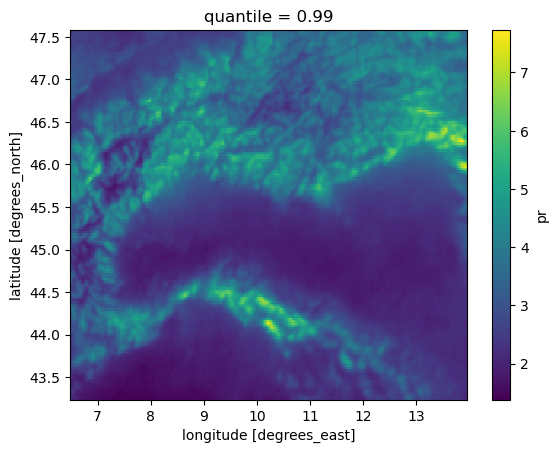

In [14]:
ds.pr.quantile(0.99,dim='time').plot()

In [29]:
MODEL=['KIT','KNMI','CNRM','ICTP','CMCC','HCLIMcom','MOHC','ETH']

for mdl in MODEL:
    directories = os.listdir(f'/mnt/beegfs/lcesarini/BIAS_CORRECTED/Rcp85/EQM/{mdl}/pr/')
    files = glob(f'/mnt/beegfs/lcesarini/BIAS_CORRECTED/Rcp85/EQM/{mdl}/pr/*nc')
    if "Historical" in files: print(f"{mdl}: {len(files)}")

In [22]:
os.listdir(f'/mnt/beegfs/lcesarini/BIAS_CORRECTED/Rcp85/EQM/{mdl}/pr/')[0]

'2096_MOHC_CORR_ECMWF-ERAINT_SPHERA_MAM_Q900_far_2000_2010_northern_italy.nc'

In [55]:
from xclim.core.calendar import common_calendar,get_calendar

list_ds[3].convert_calendar('standard',align_on='year')
print(get_calendar(list_ds[3]))

360_day


In [42]:
QDM = sdba.QuantileDeltaMapping.train(
        list_ds[3].convert_calendar('standard',align_on='year').isel(lon=1,lat=1).pr.assign_attrs(units="mm/hr"),
        list_ds[2].isel(lon=1,lat=1).pr.assign_attrs(units="mm/hr"),
        nquantiles=np.arange(0.1,0.9,0.01), 
        group="time", 
        kind="+"
    )

In [43]:
adjusted=QDM.adjust(list_ds[4].isel(lon=1,lat=1).pr.assign_attrs(units="mm/hr"))



<xarray.DataArray (time: 8760)>
dask.array<eq, shape=(8760,), dtype=bool, chunksize=(8760,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1999-01-01T00:30:00 ... 1999-12-31T23:30:00
    lat      float64 43.28
    lon      float64 6.527

In [50]:
np.allclose(adjusted.values,list_ds[4].isel(lon=1,lat=1).pr.values,rtol=1e-9)

False

In [52]:
adjusted.values.mean(),list_ds[4].isel(lon=1,lat=1).pr.values.mean()

(0.12200715, 0.123524636)

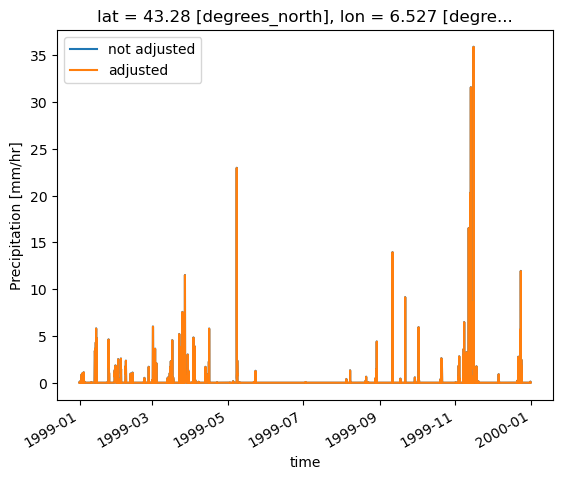

In [45]:
fig,ax=plt.subplots()
list_ds[4].isel(lon=1,lat=1).pr.plot(ax=ax,label='not adjusted')
adjusted.plot(ax=ax,label='adjusted')
# list_ds[2].isel(lon=1,lat=1).pr.plot(ax=ax, label='reference')

plt.legend()

In [53]:
def get_range_yrs(mdl:str)->np.ndarray:
    """
    Find the start and finish year for the model.    
    """
    ll_files=glob(f"/mnt/beegfs/lcesarini/DATA_FPS/Historical/{mdl}/CPM/pr/*.nc")

    years=[]
    if (len(ll_files)==0) or (mdl=="FZJ-IBG3-WRF381CA") or (mdl=="FZJ-IDL-WRF381DA"):
        pass    
    else:
        for file in ll_files:
            years.append(int(os.path.basename(file).split('_')[2][:4]))
        
    return np.arange(min(years),max(years)+1)


In [54]:
mdl='CNRM'
range_yrs=get_range_yrs(mdl)
if (range_yrs.shape[0] % 2 != 0):
    print("Odd number of years") 

yrs_train = range_yrs[:range_yrs.shape[0]//2]
yrs_valid = range_yrs[range_yrs.shape[0]//2:]

yrs_train

array([1996, 1997, 1998, 1999, 2000])

In [ ]:
ti voglio tanto benissimo

In [27]:
for name,mdl in zip(MODEL,list_ds):
    print(f"{name}:{mdl.time}")

KIT:<xarray.DataArray 'time' (time: 8760)>
array(['1999-01-01T00:30:00.000000000', '1999-01-01T01:30:00.000000000',
       '1999-01-01T02:30:00.000000000', ..., '1999-12-31T21:30:00.000000000',
       '1999-12-31T22:30:00.000000000', '1999-12-31T23:30:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1999-01-01T00:30:00 ... 1999-12-31T23:30:00
Attributes:
    standard_name:  time
    long_name:      time
    bounds:         time_bnds
    axis:           T
KNMI:<xarray.DataArray 'time' (time: 8760)>
array(['1999-01-01T00:30:00.000000000', '1999-01-01T01:30:00.000000000',
       '1999-01-01T02:30:00.000000000', ..., '1999-12-31T21:30:00.000000000',
       '1999-12-31T22:30:00.000000000', '1999-12-31T23:30:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1999-01-01T00:30:00 ... 1999-12-31T23:30:00
Attributes:
    standard_name:  time
    long_name:      Time
    bounds:         time_bnds
    axis:    

In [11]:

list_ref_train=[glob(f"{PATH_COMMON_DATA}/reanalysis/SPHERA/pr/*{year}*") for year in np.arange(2000,2001)]
list_xr=[xr.open_dataset(xr.backends.NetCDF4DataStore(Dataset(path, mode='r'))) for path in get_unlist(list_ref_train)]
ref_train_old=xr.concat(list_xr,dim='time')

surface


In [12]:

list_ref_train=[glob(f"/mnt/beegfs/lcesarini/SPHERA/decumulated/new//*{year}*") for year in np.arange(2000,2001)]
list_xr=[xr.open_dataset(xr.backends.NetCDF4DataStore(Dataset(path, mode='r'))) for path in get_unlist(list_ref_train)]
ref_train_new=xr.concat(list_xr,dim='time')

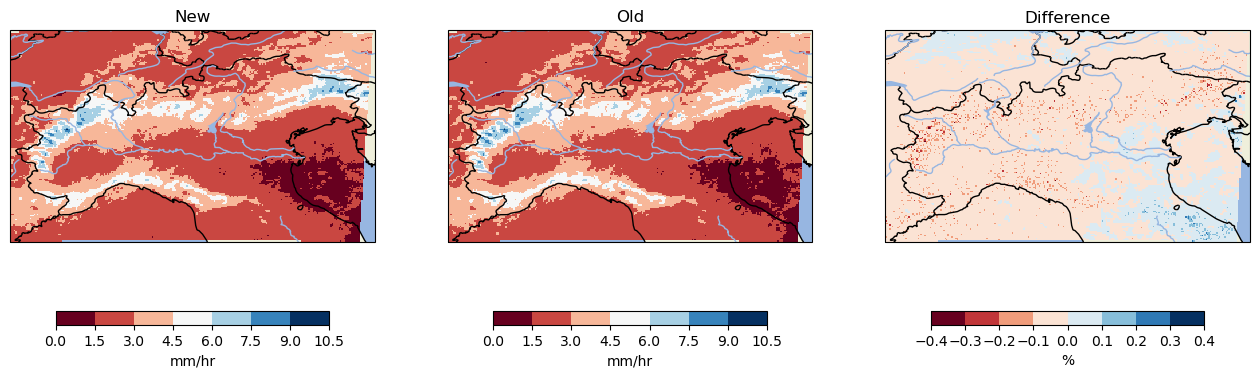

In [14]:
fig,ax=plt.subplots(1,3,figsize=(16,6),subplot_kw={'projection':ccrs.PlateCarree()})

ref_train_new.pr.quantile(q=0.99,dim='time').plot(
    cmap='RdBu',levels=9,ax=ax[0], 
    cbar_kwargs={'label':'mm/hr','orientation':'horizontal','shrink':0.75}
    )
ref_train_old.pr.quantile(q=0.99,dim='time').plot(
    cmap='RdBu',levels=9,ax=ax[1], 
    cbar_kwargs={'label':'mm/hr','orientation':'horizontal','shrink':0.75}
    )


((ref_train_new.pr.quantile(q=0.99,dim='time') - ref_train_old.pr.quantile(q=0.99,dim='time')) \
#  / ref_train_old.pr.quantile(q=0.99,dim='time') * 100
 ).plot(
    cmap='RdBu',levels=9,ax=ax[2],
    cbar_kwargs={'label':'%','orientation':'horizontal','shrink':0.75}
)


for a in ax:
    a.add_feature(cfeature.BORDERS)
    a.add_feature(cfeature.COASTLINE)
    a.add_feature(cfeature.LAND)
    a.add_feature(cfeature.OCEAN)
    a.add_feature(cfeature.LAKES)
    a.add_feature(cfeature.RIVERS)
    # a.set_extent([5,20,40,50])
    a.set_title('New' if a==ax[0] else 'Old' if a==ax[1] else 'Difference')

plt.show()

In [ ]:
ref_train=xr.concat(list_xr,dim='time')

In [26]:
mod_eqm_historical=xr.open_mfdataset(f"{PATH_BIAS_CORRECTED}Rcp85/EQM/CMCC/pr/*_CMCC_CORR_Historical_SPHERA_JJA_Q900_far_2000_2010_northern_italy.nc").load()
mod_qdm_historical=xr.open_mfdataset(f"{PATH_BIAS_CORRECTED}Rcp85/QDM/CMCC/pr/*_CMCC_CORR_Historical_SPHERA_JJA_Q900_far_2000_2010_northern_italy.nc").load()
mod_eqm_evaluation=xr.open_mfdataset('/mnt/beegfs/giorgia.fosser/BIAS_CORRECTED/Rcp85/EQM/CMCC/pr/*_CMCC_CORR_SPHERA_JJA_Q900_far_2000_2010_northern_italy.nc').load()

In [29]:
mod_biased_evaluation=xr.open_mfdataset([f"{PATH_COMMON_DATA}/Rcp85/CMCC/CPM/pr/CMCC_Rcp85_{yr}01010030-{yr}12312330.nc" for yr in np.arange(2090,2100)]).load()

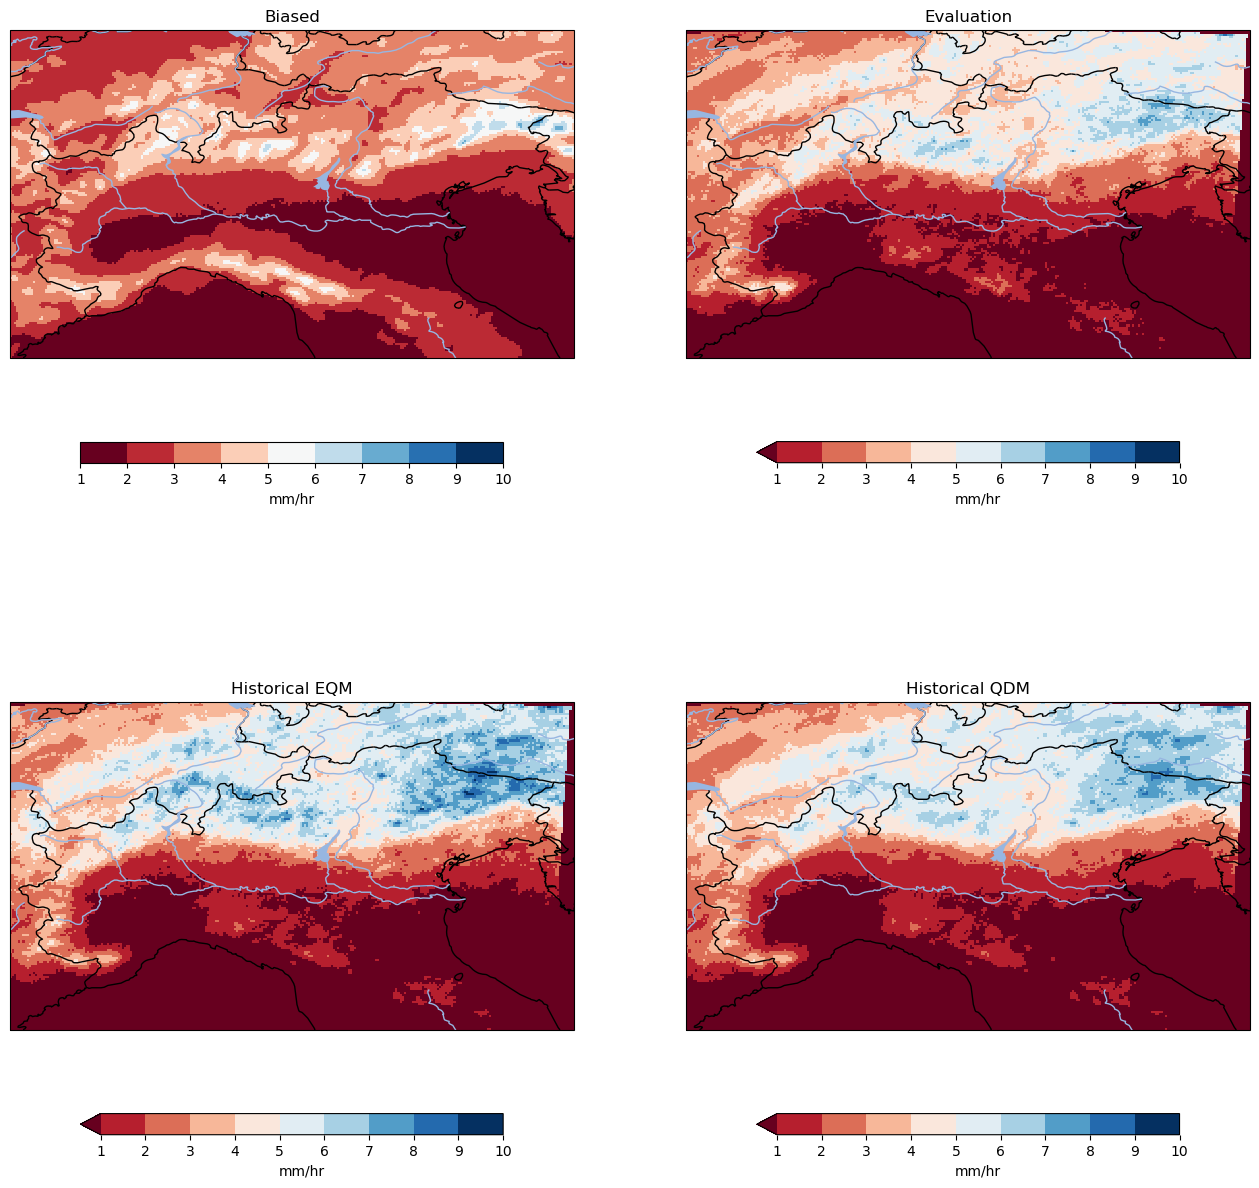

In [31]:
lvl_pr=np.arange(1,11,1)

fig,ax=plt.subplots(2,2,figsize=(16,16),subplot_kw={'projection':ccrs.PlateCarree()})
ax=ax.flatten()

mod_biased_evaluation.pr.quantile(q=0.99,dim='time').plot(
    cmap='RdBu',levels=lvl_pr,ax=ax[0], 
    cbar_kwargs={'label':'mm/hr','orientation':'horizontal','shrink':0.75}
    )

mod_eqm_evaluation.pr.quantile(q=0.99,dim='time').plot(
    cmap='RdBu',levels=lvl_pr,ax=ax[1], 
    cbar_kwargs={'label':'mm/hr','orientation':'horizontal','shrink':0.75}
    )

mod_eqm_historical.pr.quantile(q=0.99,dim='time').plot(
    cmap='RdBu',levels=lvl_pr,ax=ax[2], 
    cbar_kwargs={'label':'mm/hr','orientation':'horizontal','shrink':0.75}
    )

mod_qdm_historical.pr.quantile(q=0.99,dim='time').plot(
    cmap='RdBu',levels=lvl_pr,ax=ax[3], 
    cbar_kwargs={'label':'mm/hr','orientation':'horizontal','shrink':0.75}
    )

# ((mod_eqm_historical.pr.quantile(q=0.99,dim='time') - mod_eqm_evaluation.pr.quantile(q=0.99,dim='time')) / mod_eqm_historical.pr.quantile(q=0.99,dim='time') * 100).plot(
#     cmap='RdBu',levels=9,ax=ax[2],
#     cbar_kwargs={'label':'%','orientation':'horizontal','shrink':0.75}
# )


for a in ax:
    a.add_feature(cfeature.BORDERS)
    a.add_feature(cfeature.COASTLINE)
    a.add_feature(cfeature.LAND)
    a.add_feature(cfeature.OCEAN)
    a.add_feature(cfeature.LAKES)
    a.add_feature(cfeature.RIVERS)
    # a.set_extent([5,20,40,50])
    a.set_title('Biased' if a==ax[0] else 'Evaluation' if a==ax[1] else 'Historical EQM' if a==ax[2] else 'Historical QDM')

plt.show()

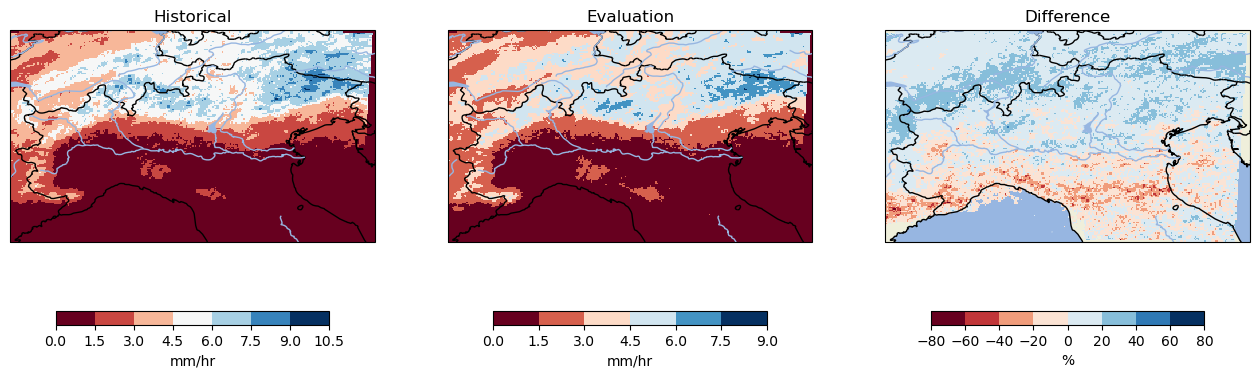

In [23]:
fig,ax=plt.subplots(1,3,figsize=(16,6),subplot_kw={'projection':ccrs.PlateCarree()})

mod_eqm_historical.pr.quantile(q=0.99,dim='time').plot(
    cmap='RdBu',levels=9,ax=ax[0], 
    cbar_kwargs={'label':'mm/hr','orientation':'horizontal','shrink':0.75}
    )
mod_eqm_evaluation.pr.quantile(q=0.99,dim='time').plot(
    cmap='RdBu',levels=9,ax=ax[1], 
    cbar_kwargs={'label':'mm/hr','orientation':'horizontal','shrink':0.75}
    )


((mod_eqm_historical.pr.quantile(q=0.99,dim='time') - mod_eqm_evaluation.pr.quantile(q=0.99,dim='time')) / mod_eqm_historical.pr.quantile(q=0.99,dim='time') * 100).plot(
    cmap='RdBu',levels=9,ax=ax[2],
    cbar_kwargs={'label':'%','orientation':'horizontal','shrink':0.75}
)


for a in ax:
    a.add_feature(cfeature.BORDERS)
    a.add_feature(cfeature.COASTLINE)
    a.add_feature(cfeature.LAND)
    a.add_feature(cfeature.OCEAN)
    a.add_feature(cfeature.LAKES)
    a.add_feature(cfeature.RIVERS)
    # a.set_extent([5,20,40,50])
    a.set_title('Historical' if a==ax[0] else 'Evaluation' if a==ax[1] else 'Difference')

plt.show()

In [3]:
"""
QM bias correction only on the wet hours.
"""
if MODEL_TRAIN == "Historical":
    yrs_train_mod=np.arange(1996,2006)
    yrs_train=np.arange(2000,2010)
else:
    yrs_train_mod=np.arange(2000,2010)
    yrs_train=np.arange(2000,2010)

if SLICE == 'near':
    yrs_valid=np.arange(2041,2051)
elif SLICE == 'far':
    yrs_valid=np.arange(2090,2100)
yrs_train_mod, yrs_train, yrs_valid

(array([1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005]),
 array([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009]),
 array([2090, 2091, 2092, 2093, 2094, 2095, 2096, 2097, 2098, 2099]))

In [4]:

#LOAD REFERENCE DATA
if  REF == "SPHERA":
    ref_train=get_reference_data(REF,yrs_train)

elif REF == "STATIONS":
    ref_train,max_sta=get_reference_data(REF,yrs_train)
    

In [5]:
"""
Get coordinates depending on the `AREA`
"""
if AREA =='triveneto':
    xy,xy_=get_list_coords(AREA,ref_train,max_sta)
elif AREA == "northern_italy":
    xy,xy_=get_list_coords(AREA,ref_train,ref_train)


In [9]:
"""
LOAD THE DATA FOR EACH MODEL

"""
print(f"Running:{mdl} {datetime.today().strftime('%d/%m/%Y %H:%M:%S')}")

list_mod_train=[glob(f"{PATH_COMMON_DATA}/{MODEL_TRAIN}/{mdl}/CPM/pr/*{year}*") for year in yrs_train_mod]
list_mod_adjust=[glob(f"{PATH_COMMON_DATA}/Rcp85/{mdl}/CPM/pr/*{year}*") for year in yrs_valid]
# x=xr.open_mfdataset(list_mod_adjust[0]).load()

list_mod_adjust

Running:KNMI 03/08/2024 12:27:22


[['/mnt/beegfs/lcesarini/DATA_FPS/Rcp85/KNMI/CPM/pr/KNMI_Rcp85_209001010030-209012312330.nc'],
 ['/mnt/beegfs/lcesarini/DATA_FPS/Rcp85/KNMI/CPM/pr/KNMI_Rcp85_209101010030-209112312330.nc'],
 ['/mnt/beegfs/lcesarini/DATA_FPS/Rcp85/KNMI/CPM/pr/KNMI_Rcp85_209201010030-209212312330.nc'],
 ['/mnt/beegfs/lcesarini/DATA_FPS/Rcp85/KNMI/CPM/pr/KNMI_Rcp85_209301010030-209312312330.nc'],
 ['/mnt/beegfs/lcesarini/DATA_FPS/Rcp85/KNMI/CPM/pr/KNMI_Rcp85_209401010030-209412312330.nc'],
 ['/mnt/beegfs/lcesarini/DATA_FPS/Rcp85/KNMI/CPM/pr/KNMI_Rcp85_209501010030-209512312330.nc'],
 ['/mnt/beegfs/lcesarini/DATA_FPS/Rcp85/KNMI/CPM/pr/KNMI_Rcp85_209601010030-209612312330.nc'],
 ['/mnt/beegfs/lcesarini/DATA_FPS/Rcp85/KNMI/CPM/pr/KNMI_Rcp85_209701010030-209712312330.nc'],
 ['/mnt/beegfs/lcesarini/DATA_FPS/Rcp85/KNMI/CPM/pr/KNMI_Rcp85_209801010030-209812312330.nc'],
 ['/mnt/beegfs/lcesarini/DATA_FPS/Rcp85/KNMI/CPM/pr/KNMI_Rcp85_209901010030-209912312330.nc']]

In [15]:
# mod_train=xr.open_mfdataset([item for list in list_mod_train for item in list]).load()
mod_adjust=xr.open_mfdataset([item for list in list_mod_adjust for item in list]).load()

In [16]:
mod_adjust

<xarray.Dataset>
Dimensions:    (time: 87648, bnds: 2, lon: 272, lat: 158)
Coordinates:
  * time       (time) datetime64[ns] 2090-01-01T00:30:00 ... 2099-12-31T23:30:00
  * lon        (lon) float64 6.5 6.527 6.555 6.582 ... 13.87 13.9 13.92 13.95
  * lat        (lat) float64 43.25 43.28 43.3 43.33 ... 47.48 47.51 47.54 47.57
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] 2090-01-01 ... 2100-01-01
    pr         (time, lat, lon) float32 0.0 0.0 0.0 0.0 ... 0.1284 0.1249 0.1245
Attributes: (12/31)
    CDI:                            Climate Data Interface version 1.9.8 (htt...
    history:                        Tue Jun 13 00:51:40 2023: cdo remapycon,n...
    source:                         HARMONIE Climate Modelling Community (HCL...
    institution:                    Royal Netherlands Meteorological Institute
    Conventions:                    CF-1.4
    frequency:                      1hr
    ...                             ...
    comment_1stNest:                KNMI-EC-EARTH (member r04i1p1) driven sim...
    comment_2ndNest:                actual convection permitting FPS simulati...
    references:                     https://hirlam.org/trac/wiki/HarmonieClimate
    knmi_global_comment:            converted from FA to NetCDF with gl/xtool...
    NCO:                            netCDF Operators version 4.8.1 (Homepage ...
    CDO:                            Climate Data Operators version 1.9.8 (htt...

In [14]:
xr.load_dataset("/mnt/beegfs/lcesarini/DATA_FPS/Rcp85/KNMI/CPM/pr/KNMI_Rcp85_209101010030-209112312330.nc")

<xarray.Dataset>
Dimensions:    (time: 8760, bnds: 2, lon: 272, lat: 158)
Coordinates:
  * time       (time) datetime64[ns] 2091-01-01T00:30:00 ... 2091-12-31T23:30:00
  * lon        (lon) float64 6.5 6.527 6.555 6.582 ... 13.87 13.9 13.92 13.95
  * lat        (lat) float64 43.25 43.28 43.3 43.33 ... 47.48 47.51 47.54 47.57
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] 2091-01-01 ... 2092-01-01
    pr         (time, lat, lon) float32 0.0 0.0 0.0 ... 0.002088 0.0009976
Attributes: (12/31)
    CDI:                            Climate Data Interface version 1.9.8 (htt...
    history:                        Tue Jun 13 01:25:21 2023: cdo remapycon,n...
    source:                         HARMONIE Climate Modelling Community (HCL...
    institution:                    Royal Netherlands Meteorological Institute
    Conventions:                    CF-1.4
    frequency:                      1hr
    ...                             ...
    comment_1stNest:                KNMI-EC-EARTH (member r04i1p1) driven sim...
    comment_2ndNest:                actual convection permitting FPS simulati...
    references:                     https://hirlam.org/trac/wiki/HarmonieClimate
    knmi_global_comment:            converted from FA to NetCDF with gl/xtool...
    NCO:                            netCDF Operators version 4.8.1 (Homepage ...
    CDO:                            Climate Data Operators version 1.9.8 (htt...

In [17]:
mod_train,mod_adjust=get_model_data(mdl,yrs_train_mod,list_mod_train,list_mod_adjust)


In [5]:
id_coord=xy[1000]

In [6]:
ref_train_sc,mod_train_sc,mod_adjust_sc=get_single_cell(
    REF='SPHERA',AREA='northern_italy',
    REF_TRAIN=ref_train,MOD_TRAIN=mod_train,MOD_ADJUST=mod_adjust,
    LON=id_coord[0],LAT=id_coord[1]
)

In [85]:
ref_train_sc=ref_train_sc.isel(time=ref_train_sc['time.season'].isin(seas)).sortby('time')
mod_train_sc=mod_train_sc.isel(time=mod_train_sc['time.season'].isin(seas)).sortby('time')
mod_adjust_sc=mod_adjust_sc.isel(time=mod_adjust_sc['time.season'].isin(seas)).sortby('time')


In [86]:
# .sortby('time').sortby('time')
ref_train_sc

<xarray.Dataset>
Dimensions:    (time: 22079)
Coordinates:
  * time       (time) datetime64[ns] 2000-06-01 ... 2009-08-31T23:00:00
    surface    float64 0.0
    latitude   float64 43.33
    longitude  float64 11.56
Data variables:
    pr         (time) float64 nan nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    GRIB_edition:            2
    GRIB_centre:             edzw
    GRIB_centreDescription:  Offenbach 
    GRIB_subCentre:          255
    Conventions:             CF-1.7
    institution:             Offenbach 
    history:                 2023-03-08T13:00 GRIB to CDM+CF via cfgrib-0.9.1...
    units:                   mm/hr

In [87]:
mod_adjust_sc_sorted=np.sort(mod_adjust_sc.pr.values)[~np.isnan(np.sort(mod_adjust_sc.pr.values))]
mod_train_sc_sorted=np.sort(mod_train_sc.pr.values)[~np.isnan(np.sort(mod_train_sc.pr.values))]
ref_train_sc_sorted=np.sort(ref_train_sc.pr.values)[~np.isnan(np.sort(ref_train_sc.pr.values))]

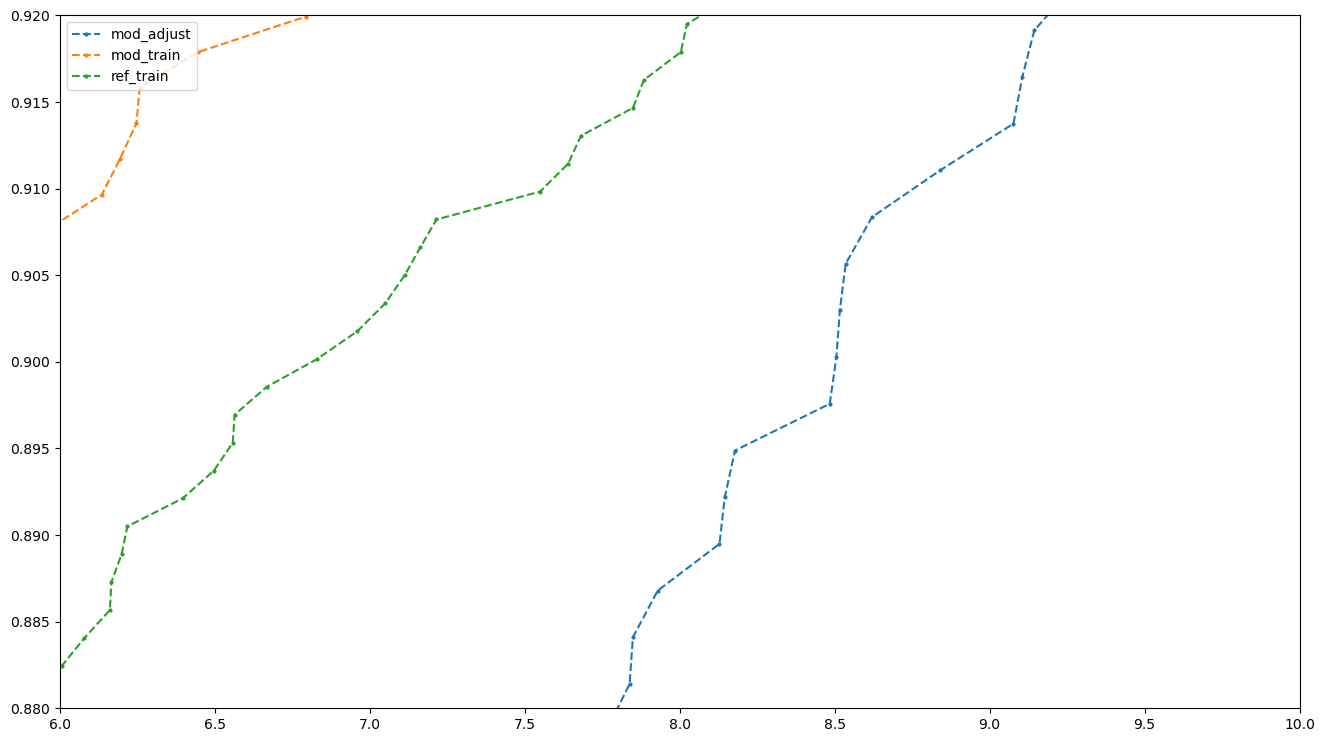

In [89]:
MS=2
LS='--'
WIDTH=16
HEIGHT=9
y0,y1=0.88,0.92
x0,x1=6,10

fig,ax=plt.subplots(1,1,figsize=(WIDTH,HEIGHT))

ax.plot(mod_adjust_sc_sorted,np.arange(mod_adjust_sc_sorted.shape[0]) / (mod_adjust_sc_sorted.shape[0] +1),
        marker='o',linestyle=LS,markersize=MS,label='mod_adjust')
ax.plot(mod_train_sc_sorted,np.arange(mod_train_sc_sorted.shape[0]) / (mod_train_sc_sorted.shape[0] +1),
        marker='o',linestyle=LS,markersize=MS,label='mod_train')   
ax.plot(ref_train_sc_sorted,np.arange(ref_train_sc_sorted.shape[0]) / (ref_train_sc_sorted.shape[0] +1),
        marker='o',linestyle=LS,markersize=MS,label='ref_train')
ax.legend(loc='upper left')
ax.set_ylim([y0,y1])
ax.set_xlim([x0,x1])
plt.show()

In [90]:
"""
Starts the correction
"""

list_xr_qdm=[]
list_xr_eqm=[]


for id_coord in xy[1000:1001]:
# for id_coord in tqdm(xy,total=42976):
    
    ref_train_sc,mod_train_sc,mod_adjust_sc=get_single_cell(
        REF='SPHERA',AREA='northern_italy',
        REF_TRAIN=ref_train,MOD_TRAIN=mod_train,MOD_ADJUST=mod_adjust,
        LON=id_coord[0],LAT=id_coord[1]
    )

    Qs=np.arange(0.1,1,0.001)

    QDM = sdba.QuantileDeltaMapping.train(
    # QM = sdba.EmpiricalQuantileMapping.train(
        ref_train_sc.isel(time=ref_train_sc['time.season'].isin(seas)).pr.assign_attrs(units="mm/hr"),
        mod_train_sc.isel(time=mod_train_sc['time.season'].isin(seas)).pr, 
        nquantiles=Qs, 
        group="time", 
        kind="+"
    )

    EQM = sdba.EmpiricalQuantileMapping.train(
        ref_train_sc.isel(time=ref_train_sc['time.season'].isin(seas)).pr.assign_attrs(units="mm/hr"),
        mod_train_sc.isel(time=mod_train_sc['time.season'].isin(seas)).pr, 
        nquantiles=Qs, 
        group="time", 
        kind="+"
    )
    if REF=="SPHERA":
        mod_adjust_sc_eqm = EQM.adjust(mod_adjust_sc.isel(time=mod_adjust_sc['time.season'].isin(seas)).pr, 
                                        extrapolation="constant", interp="nearest").drop_vars(['surface'])
        mod_adjust_sc_qdm = QDM.adjust(mod_adjust_sc.isel(time=mod_adjust_sc['time.season'].isin(seas)).pr, 
                                        extrapolation="constant", interp="nearest").drop_vars(['surface'])
        
        list_xr_qdm.append(xr.where(np.isnan(mod_adjust_sc_qdm),0,mod_adjust_sc_qdm).drop_vars(['longitude','latitude']).\
                        expand_dims(dim={"lat": 1,"lon":1}).to_dataset(name='pr'))
        list_xr_eqm.append(xr.where(np.isnan(mod_adjust_sc_eqm),0,mod_adjust_sc_eqm).drop_vars(['longitude','latitude']).\
                        expand_dims(dim={"lat": 1,"lon":1}).to_dataset(name='pr'))
    elif REF=="STATIONS":
        mod_adjust_sc_eqm = EQM.adjust(mod_adjust_sc.isel(time=mod_adjust_sc['time.season'].isin(seas)).pr,
                                        extrapolation="constant", interp="nearest")
        mod_adjust_sc_qdm = QDM.adjust(mod_adjust_sc.isel(time=mod_adjust_sc['time.season'].isin(seas)).pr,
                                        extrapolation="constant", interp="nearest")
        
        list_xr_qdm.append(xr.where(np.isnan(mod_adjust_sc_qdm),0,mod_adjust_sc_qdm).\
                        expand_dims(dim={"lat": 1,"lon":1}).to_dataset(name='pr'))
        list_xr_eqm.append(xr.where(np.isnan(mod_adjust_sc_eqm),0,mod_adjust_sc_eqm).\
                        expand_dims(dim={"lat": 1,"lon":1}).to_dataset(name='pr'))
        
        if xy_[0].shape[0] > 0:
            for id_coord in xy_:
                if REF == "SPHERA":
                    lon=max_sta.isel(lon=id_coord[0],lat=id_coord[1]).lon.item()
                    lat=max_sta.isel(lon=id_coord[0],lat=id_coord[1]).lat.item()
                elif REF == "STATIONS":
                    lon=ref_train.isel(lon=id_coord[0],lat=id_coord[1]).lon.item()
                    lat=ref_train.isel(lon=id_coord[0],lat=id_coord[1]).lat.item()
            
                na_sta_sc=mod_adjust.sel(lon=lon,lat=lat,method='nearest').isel(time=mod_adjust['time.season'].isin(seas))
                list_xr_qdm.append(xr.where(np.isnan(na_sta_sc),0,np.nan).expand_dims(dim={"lat": 1,"lon":1})[["time","lat","lon","pr"]])
                list_xr_eqm.append(xr.where(np.isnan(na_sta_sc),0,np.nan).expand_dims(dim={"lat": 1,"lon":1})[["time","lat","lon","pr"]])




In [91]:
ds_adj_qdm=xr.combine_by_coords(list_xr_qdm)
ds_adj_eqm=xr.combine_by_coords(list_xr_eqm)
ds_adj_eqm

<xarray.Dataset>
Dimensions:  (time: 22080, lon: 1, lat: 1)
Coordinates:
  * time     (time) datetime64[ns] 2090-06-01T00:33:00 ... 2099-08-31T23:33:00
  * lon      (lon) float64 11.56
  * lat      (lat) float64 43.33
Data variables:
    pr       (lat, lon, time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

In [92]:
mod_adjust_eqm_sorted=np.sort(ds_adj_eqm.pr.values[ds_adj_eqm.pr.values > 0.05])
mod_adjust_qdm_sorted=np.sort(ds_adj_qdm.pr.values[ds_adj_qdm.pr.values > 0.05])

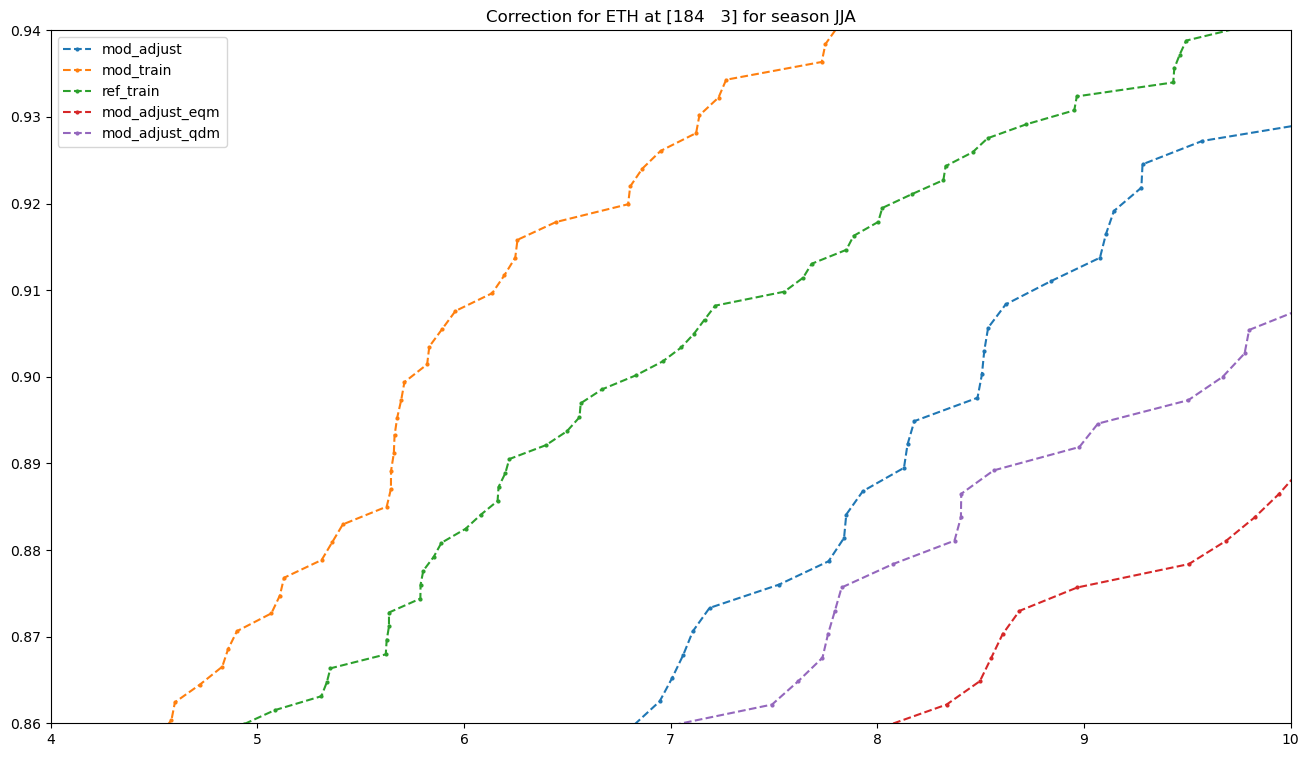

In [95]:
MS=2
LS='--'
WIDTH=16
HEIGHT=9
y0,y1=0.86,0.94
x0,x1=4,10

fig,ax=plt.subplots(1,1,figsize=(WIDTH,HEIGHT))

ax.plot(mod_adjust_sc_sorted,np.arange(mod_adjust_sc_sorted.shape[0]) / (mod_adjust_sc_sorted.shape[0] +1),
        marker='o',linestyle=LS,markersize=MS,label='mod_adjust')
ax.plot(mod_train_sc_sorted,np.arange(mod_train_sc_sorted.shape[0]) / (mod_train_sc_sorted.shape[0] +1),
        marker='o',linestyle=LS,markersize=MS,label='mod_train')   
ax.plot(ref_train_sc_sorted,np.arange(ref_train_sc_sorted.shape[0]) / (ref_train_sc_sorted.shape[0] +1),
        marker='o',linestyle=LS,markersize=MS,label='ref_train')
ax.plot(mod_adjust_eqm_sorted,np.arange(mod_adjust_eqm_sorted.shape[0]) / (mod_adjust_eqm_sorted.shape[0] +1),
        marker='o',linestyle=LS,markersize=MS,label='mod_adjust_eqm')
ax.plot(mod_adjust_qdm_sorted,np.arange(mod_adjust_qdm_sorted.shape[0]) / (mod_adjust_qdm_sorted.shape[0] +1),
        marker='o',linestyle=LS,markersize=MS,label='mod_adjust_qdm')

ax.legend(loc='upper left')
ax.set_ylim([y0,y1])
ax.set_xlim([x0,x1])
ax.set_title(f"Correction for {mdl} at {id_coord} for season {seas}")
plt.show()

In [ ]:
ds_adj_qdm=xr.combine_by_coords(list_xr_qdm)
ds_adj_eqm=xr.combine_by_coords(list_xr_eqm)

if not os.path.exists(f"{PATH_BIAS_CORRECTED}/Rcp85/QDM/{mdl}/pr/"):
    os.makedirs(f"{PATH_BIAS_CORRECTED}/Rcp85/QDM/{mdl}/pr/")

if not os.path.exists(f"{PATH_BIAS_CORRECTED}/Rcp85/EQM/{mdl}/pr/"):
    os.makedirs(f"{PATH_BIAS_CORRECTED}/Rcp85/EQM/{mdl}/pr/")


for YR in np.unique(ds_adj_eqm['time.year']):
    ds_adj_eqm.isel(time=ds_adj_eqm['time.year'].isin(YR)).to_netcdf(f"{PATH_BIAS_CORRECTED}/Rcp85/EQM/{mdl}/pr/{YR}_{mdl}_CORR_{REF}_{seas}_Q{Qs.shape[0]}_{SLICE}_{ADJUST}_{AREA}.nc")    
    ds_adj_qdm.isel(time=ds_adj_eqm['time.year'].isin(YR)).to_netcdf(f"{PATH_BIAS_CORRECTED}/Rcp85/QDM/{mdl}/pr/{YR}_{mdl}_CORR_{REF}_{seas}_Q{Qs.shape[0]}_{SLICE}_{ADJUST}_{AREA}.nc")



In [102]:
"""
Starts the correction
"""

list_xr_qdm=[]
list_xr_eqm=[]


for id_coord in xy[1000:1001]:
# for id_coord in tqdm(xy,total=42976):
    
    ref_train_sc,mod_train_sc,mod_adjust_sc=get_single_cell(
        REF='SPHERA',AREA='northern_italy',
        REF_TRAIN=ref_train,MOD_TRAIN=mod_train,MOD_ADJUST=mod_adjust,
        LON=id_coord[0],LAT=id_coord[1]
    )

    Qs=np.arange(0.1,1,0.001)

    QDM = sdba.QuantileDeltaMapping.train(
    # QM = sdba.EmpiricalQuantileMapping.train(
        ref_train_sc.isel(time=ref_train_sc['time.season'].isin(seas)).pr.assign_attrs(units="mm/hr"),
        mod_adjust_sc.isel(time=mod_adjust_sc['time.season'].isin(seas)).pr, 
        nquantiles=Qs, 
        group="time", 
        kind="+"
    )

    EQM = sdba.EmpiricalQuantileMapping.train(
        ref_train_sc.isel(time=ref_train_sc['time.season'].isin(seas)).pr.assign_attrs(units="mm/hr"),
        mod_adjust_sc.isel(time=mod_adjust_sc['time.season'].isin(seas)).pr, 
        nquantiles=Qs, 
        group="time", 
        kind="+"
    )
    if REF=="SPHERA":
        mod_adjust_sc_eqm = EQM.adjust(mod_adjust_sc.isel(time=mod_adjust_sc['time.season'].isin(seas)).pr, 
                                        extrapolation="constant", interp="nearest").drop_vars(['surface'])
        mod_adjust_sc_qdm = QDM.adjust(mod_adjust_sc.isel(time=mod_adjust_sc['time.season'].isin(seas)).pr, 
                                        extrapolation="constant", interp="nearest").drop_vars(['surface'])
        
        list_xr_qdm.append(xr.where(np.isnan(mod_adjust_sc_qdm),0,mod_adjust_sc_qdm).drop_vars(['longitude','latitude']).\
                        expand_dims(dim={"lat": 1,"lon":1}).to_dataset(name='pr'))
        list_xr_eqm.append(xr.where(np.isnan(mod_adjust_sc_eqm),0,mod_adjust_sc_eqm).drop_vars(['longitude','latitude']).\
                        expand_dims(dim={"lat": 1,"lon":1}).to_dataset(name='pr'))
    elif REF=="STATIONS":
        mod_adjust_sc_eqm = EQM.adjust(mod_adjust_sc.isel(time=mod_adjust_sc['time.season'].isin(seas)).pr,
                                        extrapolation="constant", interp="nearest")
        mod_adjust_sc_qdm = QDM.adjust(mod_adjust_sc.isel(time=mod_adjust_sc['time.season'].isin(seas)).pr,
                                        extrapolation="constant", interp="nearest")
        
        list_xr_qdm.append(xr.where(np.isnan(mod_adjust_sc_qdm),0,mod_adjust_sc_qdm).\
                        expand_dims(dim={"lat": 1,"lon":1}).to_dataset(name='pr'))
        list_xr_eqm.append(xr.where(np.isnan(mod_adjust_sc_eqm),0,mod_adjust_sc_eqm).\
                        expand_dims(dim={"lat": 1,"lon":1}).to_dataset(name='pr'))
        
        if xy_[0].shape[0] > 0:
            for id_coord in xy_:
                if REF == "SPHERA":
                    lon=max_sta.isel(lon=id_coord[0],lat=id_coord[1]).lon.item()
                    lat=max_sta.isel(lon=id_coord[0],lat=id_coord[1]).lat.item()
                elif REF == "STATIONS":
                    lon=ref_train.isel(lon=id_coord[0],lat=id_coord[1]).lon.item()
                    lat=ref_train.isel(lon=id_coord[0],lat=id_coord[1]).lat.item()
            
                na_sta_sc=mod_adjust.sel(lon=lon,lat=lat,method='nearest').isel(time=mod_adjust['time.season'].isin(seas))
                list_xr_qdm.append(xr.where(np.isnan(na_sta_sc),0,np.nan).expand_dims(dim={"lat": 1,"lon":1})[["time","lat","lon","pr"]])
                list_xr_eqm.append(xr.where(np.isnan(na_sta_sc),0,np.nan).expand_dims(dim={"lat": 1,"lon":1})[["time","lat","lon","pr"]])


ds_adj_qdm=xr.combine_by_coords(list_xr_qdm)
ds_adj_eqm=xr.combine_by_coords(list_xr_eqm)

In [103]:
mod_adjust_eqm_sorted=np.sort(ds_adj_eqm.pr.values[ds_adj_eqm.pr.values > 0.05])
mod_adjust_qdm_sorted=np.sort(ds_adj_qdm.pr.values[ds_adj_qdm.pr.values > 0.05])

In [106]:
mod_adjust_sc_sorted.shape

(370,)

In [107]:
ref_train_sc_sorted.shape

(620,)

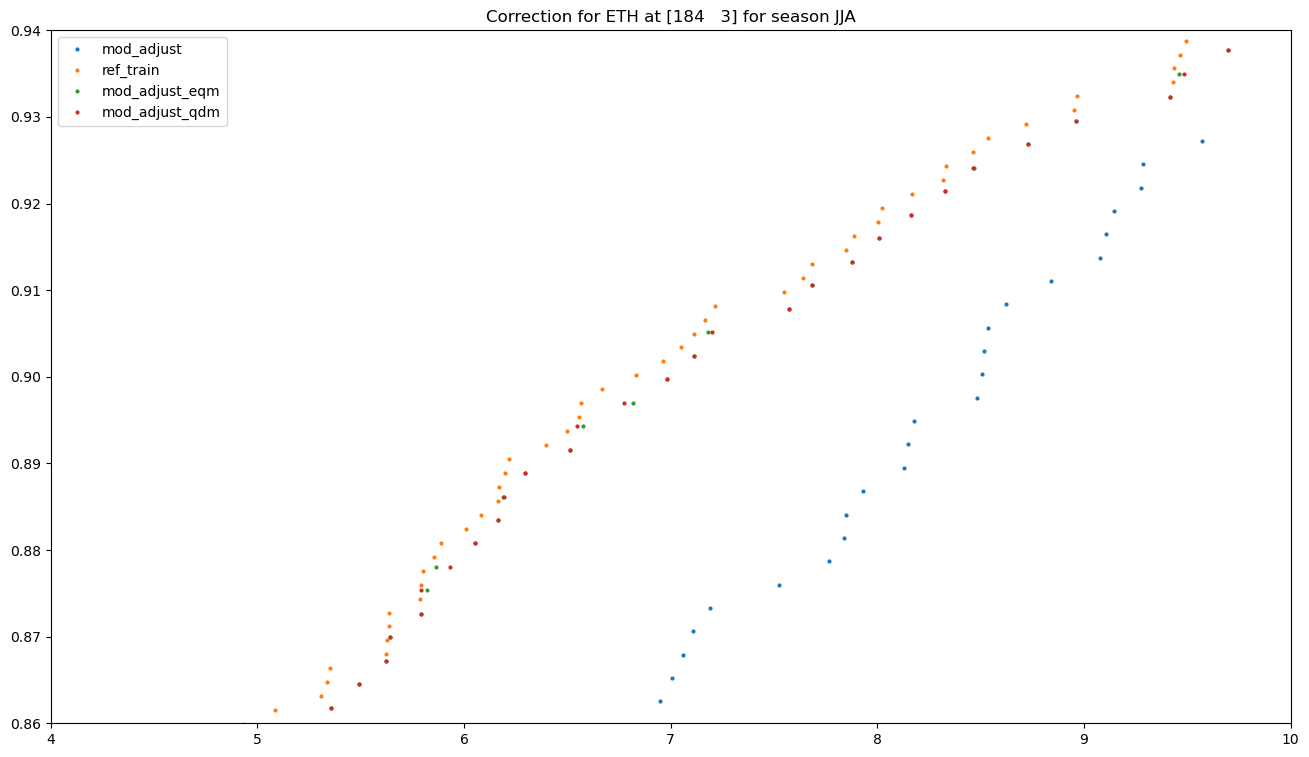

In [105]:
MS=2
LS=''
WIDTH=16
HEIGHT=9
y0,y1=0.86,0.94
x0,x1=4,10

fig,ax=plt.subplots(1,1,figsize=(WIDTH,HEIGHT))

ax.plot(mod_adjust_sc_sorted,np.arange(mod_adjust_sc_sorted.shape[0]) / (mod_adjust_sc_sorted.shape[0] +1),
        marker='o',linestyle=LS,markersize=MS,label='mod_adjust')
# ax.plot(mod_train_sc_sorted,np.arange(mod_train_sc_sorted.shape[0]) / (mod_train_sc_sorted.shape[0] +1),
#         marker='o',linestyle=LS,markersize=MS,label='mod_train')   
ax.plot(ref_train_sc_sorted,np.arange(ref_train_sc_sorted.shape[0]) / (ref_train_sc_sorted.shape[0] +1),
        marker='o',linestyle=LS,markersize=MS,label='ref_train')
ax.plot(mod_adjust_eqm_sorted,np.arange(mod_adjust_eqm_sorted.shape[0]) / (mod_adjust_eqm_sorted.shape[0] +1),
        marker='o',linestyle=LS,markersize=MS,label='mod_adjust_eqm')
ax.plot(mod_adjust_qdm_sorted,np.arange(mod_adjust_qdm_sorted.shape[0]) / (mod_adjust_qdm_sorted.shape[0] +1),
        marker='o',linestyle=LS,markersize=MS,label='mod_adjust_qdm')

ax.legend(loc='upper left')
ax.set_ylim([y0,y1])
ax.set_xlim([x0,x1])
ax.set_title(f"Correction for {mdl} at {id_coord} for season {seas}")
plt.show()

In [116]:
np.mean(ref_train_sc_sorted),np.quantile(ref_train_sc_sorted,0.95)

(2.336934406526627, 10.340157318115233)

In [117]:
np.mean(mod_adjust_sc_sorted),np.quantile(mod_adjust_sc_sorted,0.95)


(2.954662, 11.321884679794316)

In [118]:
np.mean(mod_adjust_eqm_sorted),np.quantile(mod_adjust_eqm_sorted,0.95)

(2.3610461205495175, 10.288188310480033)

In [120]:
np.mean(mod_adjust_qdm_sorted),np.quantile(mod_adjust_qdm_sorted,0.95)

(2.358591752454277, 10.294662189960391)